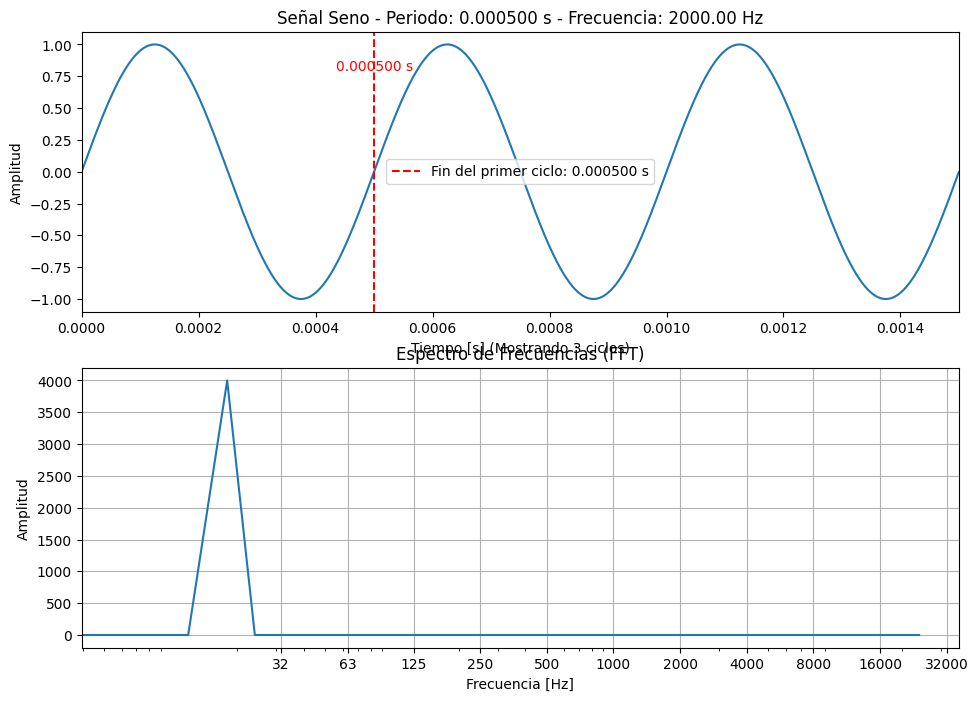

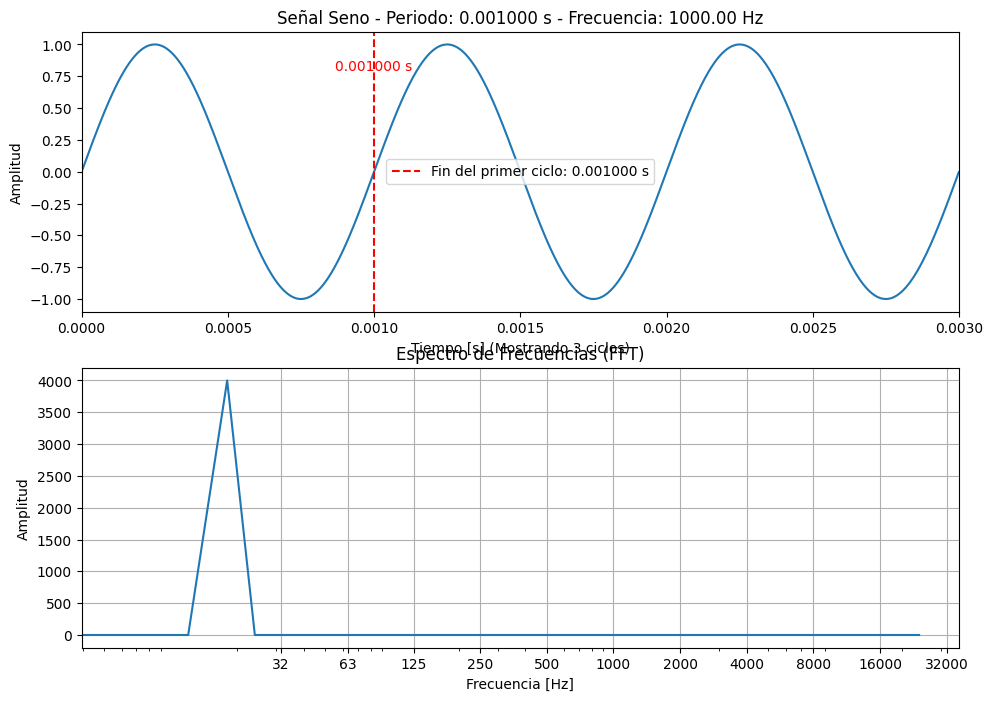

C:\Users\Alejandro Urbina\AppData\Local\Temp\ipykernel_10700\3531489663.py:91: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  canvas.draw()


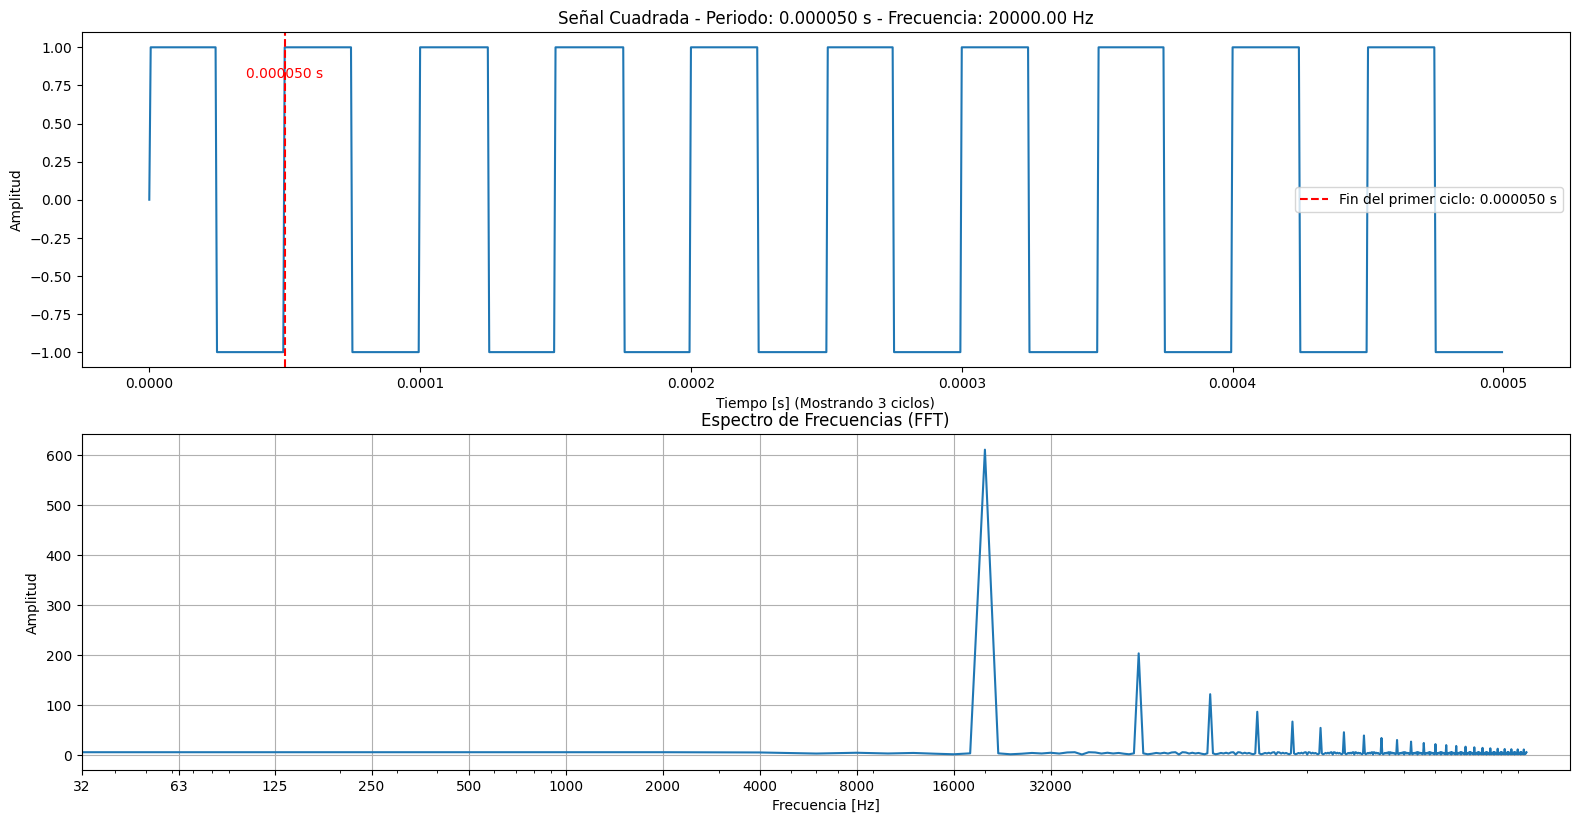

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk

# Frecuencia de muestreo fija en 48 kHz
#la cambie a 1920000 porque habia un problema con la frecuencia de muestreo 
fs = 1920000
tipo_senal = 'seno'  # Valor por defecto
octave_bands = np.array([31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000, 32000])

# Lista de periodos discretos proporcionada
periodos = [
    5e-05, 6.25e-05, 8e-05, 0.0001, 0.000125, 0.00015873015873015873,
    0.0002, 0.00025, 0.00031746031746031746, 0.0004, 0.0005, 0.000625, 
    0.0008, 0.001, 0.00125, 0.0015873015873015873, 0.002, 0.0025, 
    0.0031746031746031746, 0.004, 0.005, 0.00625, 0.008, 0.01, 0.0125, 
    0.015873015873015872, 0.02, 0.025, 0.031746031746031744, 0.04, 0.05
]

# Función para generar diferentes señales periódicas
def generar_senal(tipo, frecuencia, ciclos=10):  # Aumentamos los ciclos a 10
    num_puntos = int(fs * ciclos / frecuencia)  # Aseguramos suficientes puntos
    t = np.linspace(0, ciclos / frecuencia, num_puntos, endpoint=False)
    
    if tipo == 'seno':
        senal = np.sin(2 * np.pi * frecuencia * t)
    elif tipo == 'cuadrada':
        senal = np.sign(np.sin(2 * np.pi * frecuencia * t))
    elif tipo == 'trapezoidal':
        senal = np.piecewise(t, [np.mod(t, 1/frecuencia) < (1/frecuencia)/2, np.mod(t, 1/frecuencia) >= (1/frecuencia)/2], 
                             [lambda x: 4 * frecuencia * x - 1, lambda x: -4 * frecuencia * x + 3])
    elif tipo == 'triangular':
        senal = 2 * np.abs(2 * (t * frecuencia - np.floor(0.5 + t * frecuencia))) - 1
    elif tipo == 'diente-de-sierra':
        senal = 2 * (t * frecuencia - np.floor(0.5 + t * frecuencia))
    
    return t, senal

# Función para calcular la FFT sin normalización
def calcular_fft(senal):
    N = len(senal)  # Usamos la longitud completa de la señal
    espectro = np.fft.fft(senal)  # Eliminamos la normalización
    frecuencias = np.fft.fftfreq(N, 1/fs)
    espectro_positivas = np.abs(espectro[:N // 2])  # Solo la mitad positiva
    frecuencias_positivas = frecuencias[:N // 2]
    return frecuencias_positivas, espectro_positivas

# Función para actualizar la gráfica
def actualizar_grafica(val):
    index = int(val)
    if index < len(periodos):
        periodo = periodos[index]
    else:
        incremento = 0.05 * (1.2 ** (index - len(periodos)))  # Crecimiento exponencial
        periodo = periodos[-1] + incremento

    if periodo > 0:
        frecuencia = 1 / periodo
        ciclos = 10  # Aseguramos más ciclos para la FFT
        
        # Generar la señal seleccionada
        t, senal = generar_senal(tipo_senal, frecuencia, ciclos)
        
        # Calcular la FFT
        freqs, espectro = calcular_fft(senal)
        
        # Limpiar las gráficas
        ax.clear()
        ax_fft.clear()

        # Graficar la señal en el dominio del tiempo
        ax.plot(t, senal)
        ax.axvline(x=periodo, color='red', linestyle='--', label=f'Fin del primer ciclo: {periodo:.6f} s')
        ax.text(periodo, 0.8, f'{periodo:.6f} s', color='red', ha='center')
        ax.set_title(f'Señal {tipo_senal.capitalize()} - Periodo: {periodo:.6f} s - Frecuencia: {frecuencia:.2f} Hz')
        ax.set_xlabel('Tiempo [s] (Mostrando 3 ciclos)')
        ax.set_ylabel('Amplitud')
        ax.legend()
        
        # Graficar el espectro de frecuencias
        ax_fft.plot(freqs, espectro)
        ax_fft.set_xscale('log')  # Escala logarítmica para el eje x
        ax_fft.set_title('Espectro de Frecuencias (FFT)')
        ax_fft.set_xlabel('Frecuencia [Hz]')
        ax_fft.set_ylabel('Amplitud')
        ax_fft.set_xticks(octave_bands)  # Usar las bandas de octava como ticks
        ax_fft.get_xaxis().set_major_formatter(plt.ScalarFormatter())  # Mostrar los ticks como números
        ax_fft.grid(True)
        
        # Actualizar las gráficas
        canvas.draw()

# Función para cambiar el tipo de señal
def seleccionar_senal(tipo):
    global tipo_senal
    tipo_senal = tipo
    actualizar_grafica(slider_periodo.get())

# Crear la ventana principal
root = tk.Tk()
root.title("Generador de Señales Periódicas y Espectro de Frecuencias")

# Crear el gráfico utilizando Matplotlib
fig, (ax, ax_fft) = plt.subplots(2, 1, figsize=(6, 8))  # Gráfica en dos filas (tiempo y FFT)
canvas = FigureCanvasTkAgg(fig, master=root)  # Integrar Matplotlib con Tkinter
canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

# Botones para seleccionar el tipo de señal
tk.Button(root, text="Seno", command=lambda: seleccionar_senal('seno')).pack(side=tk.LEFT)
tk.Button(root, text="Cuadrada", command=lambda: seleccionar_senal('cuadrada')).pack(side=tk.LEFT)
tk.Button(root, text="Trapezoidal", command=lambda: seleccionar_senal('trapezoidal')).pack(side=tk.LEFT)
tk.Button(root, text="Triangular", command=lambda: seleccionar_senal('triangular')).pack(side=tk.LEFT)
tk.Button(root, text="Diente de sierra", command=lambda: seleccionar_senal('diente-de-sierra')).pack(side=tk.LEFT)

# Crear el slider para controlar el periodo
slider_periodo = tk.Scale(root, from_=0, to=60, orient=tk.HORIZONTAL, resolution=1, length=800,
                          label="Periodo (Índice)", command=actualizar_grafica)
slider_periodo.pack()

# Inicializar el slider
slider_periodo.set(1)

# Ejecutar la interfaz gráfica
root.mainloop()
